In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import numpy as np
import time
import os
import matplotlib.pyplot as plt  

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchviz import make_dot
from utils import one_hot_encode, one_hot_decode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from utils import load_gfp_data, count_substring_mismatch, get_mutation

In [23]:
class VAE(nn.Module):
    
    # change architecture later to make it deeper if it's not good enough to capture all data
    def __init__(self, input_size, hidden_size, latent_dim, num_characters):
        super(VAE, self).__init__() 
        self.num_characters = num_characters
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.fc5 = nn.Linear(self.num_characters, self.num_characters)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        
    def encode(self, x):
        # input should be one hot encoded. shape - (batch_size, alphabet x sequence_length)
        h1 = F.elu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, softmax=False):
        batch_size = z.shape[0]
        h3 = F.elu(self.fc3(z))
        h4 = F.elu(self.fc4(h3)).view(batch_size, -1, self.num_characters) ## may need to add RELU here. 
        #F.elu(self.fc4(h3)).view(batch_size, -1, self.num_characters)
        h5 = self.fc5(h4)
        if softmax:
            return F.softmax(h5, dim=2)
        else:
            return h5
            
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z, softmax=False), mu, logvar

    def elbo_loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * len(all_characters)) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of size self.hidden_size
        Output: elbo_loss
        """
        # get the argmax of each batch_size x seq_length * len(all_characters) matrix. Output is in batch_size x seq_length form
        # print(labels)
        # reshapes the recon_x vector to be of shape batch_size x len(all_characters) x seq_length so that it fits according to PyTorch's CrossEntropyLoss
        # permute is transpose function so at each 1, 2 dimension we take the transpose
        # print(recon_x.shape)
        # print(reshape_x[0,:,0])
        outputs = F.log_softmax(recon_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        #print("log var shape:", logvar.shape, "mu shape: ", mu.shape, "logvar: ", logvar.sum(dim=1))
        #print("mu: ", mu.sum(dim=1))
        #print((1 + logvar - mu.pow(2) - logvar.exp()).shape)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        #print("CE Loss: ", CE, "KLD Loss:", KLD, file=logger)
        return CE + KLD
    
    def NLLoss(self, recon_x, x):
        #outputs = F.log_softmax(recon_x, dim = 2)
        #return  (-1 * outputs * x.view(x.shape[0], -1, self.num_characters)).sum()
        loss = nn.CrossEntropyLoss(reduction='sum')
        input = recon_x.permute(0, 2, 1)
        _, target = x.view(x.shape[0], -1, self.num_characters).max(dim=2)
        target = target.long()
        return loss(input, target)
    
    def KLD(self, mu, logvar): 
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

In [ ]:
train_losses, test_losses, train_kld_loss, test_kld_loss, train_recon_loss, test_recon_loss = [], [], [], [], [], []
model = VAE(21 * 238, 50, 20, 21)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
start_time = time.time()
epochs = 1000
for epoch in range(1, epochs + 1):
    train_loss, reconstruction_loss, kld_loss = 0, 0, 0
    model.train()
    for batch_idx, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        rloss, kloss = model.NLLoss(recon_x, x), model.KLD(mu, logvar)
        loss = rloss + kloss
        loss.backward()
        optimizer.step()
        #print("Batch {0}: reconstruction loss: {1} kld loss {2}".format(batch_idx, rloss, kloss))
        train_loss += loss.item()
        reconstruction_loss += rloss.item()
        kld_loss += kloss.item()
    kld_loss /= len(train_loader.dataset)
    reconstruction_loss /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)
    print('<-- Epoch: {0}. Average Train loss: {1:.4f}. Train Reconstruction loss: {2:.4f}. Train KLD loss: {3:.4f}. Time: {4:.2f}'.format(
                    epoch, train_loss, reconstruction_loss, kld_loss, time.time() - start_time))
    
    train_losses.append(train_loss); train_kld_loss.append(kld_loss); train_recon_loss.append(reconstruction_loss)
    model.eval()
    test_loss, reconstruction_loss, kld_loss = 0, 0, 0
    for batch_idx, (x, _) in enumerate(test_loader):
        recon_x, mu, logvar = model(x)
        rloss, kloss = model.NLLoss(recon_x, x), model.KLD(mu, logvar)
        loss = rloss + kloss
        test_loss += loss.item()
        reconstruction_loss += rloss.item()
        kld_loss += kloss.item()
    kld_loss /= len(test_loader.dataset)
    reconstruction_loss /= len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss); test_kld_loss.append(kld_loss); test_recon_loss.append(reconstruction_loss)
    print('<-- Epoch: {0}. Average Test loss: {1:.4f}. Test Reconstruction loss: {2:.4f}. Test KLD loss: {3:.4f}. Time: {4:.2f}'.format(
                    epoch, test_loss, reconstruction_loss, kld_loss, time.time() - start_time))

<-- Epoch: 1. Average Train loss: 182.2484. Train Reconstruction loss: 148.3594. Train KLD loss: 33.8890. Time: 1.19
<-- Epoch: 1. Average Test loss: 47.1824. Test Reconstruction loss: 33.4760. Test KLD loss: 13.7064. Time: 1.56
<-- Epoch: 2. Average Train loss: 41.2713. Train Reconstruction loss: 31.4287. Train KLD loss: 9.8426. Time: 2.58
<-- Epoch: 2. Average Test loss: 41.6451. Test Reconstruction loss: 35.5643. Test KLD loss: 6.0807. Time: 2.88
<-- Epoch: 3. Average Train loss: 36.5658. Train Reconstruction loss: 29.1410. Train KLD loss: 7.4248. Time: 3.92
<-- Epoch: 3. Average Test loss: 35.8055. Test Reconstruction loss: 30.0839. Test KLD loss: 5.7216. Time: 4.22
<-- Epoch: 4. Average Train loss: 35.4068. Train Reconstruction loss: 28.3871. Train KLD loss: 7.0197. Time: 5.26
<-- Epoch: 4. Average Test loss: 34.5089. Test Reconstruction loss: 28.3998. Test KLD loss: 6.1091. Time: 5.58
<-- Epoch: 5. Average Train loss: 33.0888. Train Reconstruction loss: 26.9185. Train KLD loss: 6

<-- Epoch: 37. Average Train loss: 22.9600. Train Reconstruction loss: 22.8903. Train KLD loss: 0.0697. Time: 48.86
<-- Epoch: 37. Average Test loss: 24.7802. Test Reconstruction loss: 24.7379. Test KLD loss: 0.0422. Time: 49.15
<-- Epoch: 38. Average Train loss: 22.9704. Train Reconstruction loss: 22.8932. Train KLD loss: 0.0773. Time: 50.14
<-- Epoch: 38. Average Test loss: 24.8063. Test Reconstruction loss: 24.7617. Test KLD loss: 0.0446. Time: 50.43
<-- Epoch: 39. Average Train loss: 22.9552. Train Reconstruction loss: 22.8748. Train KLD loss: 0.0803. Time: 51.43
<-- Epoch: 39. Average Test loss: 24.7728. Test Reconstruction loss: 24.7276. Test KLD loss: 0.0452. Time: 51.73
<-- Epoch: 40. Average Train loss: 22.9403. Train Reconstruction loss: 22.8541. Train KLD loss: 0.0863. Time: 52.73
<-- Epoch: 40. Average Test loss: 24.8162. Test Reconstruction loss: 24.7690. Test KLD loss: 0.0472. Time: 53.03
<-- Epoch: 41. Average Train loss: 22.9135. Train Reconstruction loss: 22.8226. Trai

<-- Epoch: 73. Average Train loss: 22.1701. Train Reconstruction loss: 21.1048. Train KLD loss: 1.0653. Time: 680.79
<-- Epoch: 73. Average Test loss: 25.5064. Test Reconstruction loss: 24.9516. Test KLD loss: 0.5549. Time: 681.11
<-- Epoch: 74. Average Train loss: 22.1066. Train Reconstruction loss: 20.9881. Train KLD loss: 1.1184. Time: 682.39
<-- Epoch: 74. Average Test loss: 25.6021. Test Reconstruction loss: 25.0242. Test KLD loss: 0.5780. Time: 682.75
<-- Epoch: 75. Average Train loss: 22.1219. Train Reconstruction loss: 20.9812. Train KLD loss: 1.1406. Time: 684.04
<-- Epoch: 75. Average Test loss: 25.5107. Test Reconstruction loss: 24.9059. Test KLD loss: 0.6048. Time: 684.51
<-- Epoch: 76. Average Train loss: 22.0370. Train Reconstruction loss: 20.8151. Train KLD loss: 1.2219. Time: 685.76
<-- Epoch: 76. Average Test loss: 25.5343. Test Reconstruction loss: 24.9416. Test KLD loss: 0.5927. Time: 686.09
<-- Epoch: 77. Average Train loss: 22.0167. Train Reconstruction loss: 20.78

<-- Epoch: 108. Average Test loss: 27.2466. Test Reconstruction loss: 25.4794. Test KLD loss: 1.7671. Time: 740.23
<-- Epoch: 109. Average Train loss: 20.5593. Train Reconstruction loss: 17.4330. Train KLD loss: 3.1263. Time: 742.60
<-- Epoch: 109. Average Test loss: 27.2272. Test Reconstruction loss: 25.4312. Test KLD loss: 1.7960. Time: 743.30
<-- Epoch: 110. Average Train loss: 20.4402. Train Reconstruction loss: 17.2313. Train KLD loss: 3.2090. Time: 745.39
<-- Epoch: 110. Average Test loss: 27.4312. Test Reconstruction loss: 25.6416. Test KLD loss: 1.7896. Time: 746.08
<-- Epoch: 111. Average Train loss: 20.5390. Train Reconstruction loss: 17.2221. Train KLD loss: 3.3169. Time: 748.34
<-- Epoch: 111. Average Test loss: 27.5367. Test Reconstruction loss: 25.2221. Test KLD loss: 2.3146. Time: 748.90
<-- Epoch: 112. Average Train loss: 20.4337. Train Reconstruction loss: 17.0429. Train KLD loss: 3.3908. Time: 750.92
<-- Epoch: 112. Average Test loss: 27.3984. Test Reconstruction loss

<-- Epoch: 144. Average Train loss: 18.3352. Train Reconstruction loss: 13.2289. Train KLD loss: 5.1062. Time: 800.42
<-- Epoch: 144. Average Test loss: 30.4579. Test Reconstruction loss: 27.6036. Test KLD loss: 2.8543. Time: 800.72
<-- Epoch: 145. Average Train loss: 18.3676. Train Reconstruction loss: 13.1574. Train KLD loss: 5.2102. Time: 802.02
<-- Epoch: 145. Average Test loss: 30.3995. Test Reconstruction loss: 27.1803. Test KLD loss: 3.2192. Time: 802.45
<-- Epoch: 146. Average Train loss: 18.2921. Train Reconstruction loss: 13.0446. Train KLD loss: 5.2474. Time: 803.78
<-- Epoch: 146. Average Test loss: 30.7752. Test Reconstruction loss: 27.3993. Test KLD loss: 3.3759. Time: 804.22
<-- Epoch: 147. Average Train loss: 18.3213. Train Reconstruction loss: 12.9584. Train KLD loss: 5.3630. Time: 805.71
<-- Epoch: 147. Average Test loss: 30.7502. Test Reconstruction loss: 27.4212. Test KLD loss: 3.3290. Time: 806.16
<-- Epoch: 148. Average Train loss: 18.2371. Train Reconstruction lo

<-- Epoch: 179. Average Test loss: 34.9751. Test Reconstruction loss: 30.6535. Test KLD loss: 4.3216. Time: 864.63
<-- Epoch: 180. Average Train loss: 16.4923. Train Reconstruction loss: 9.7694. Train KLD loss: 6.7230. Time: 866.46
<-- Epoch: 180. Average Test loss: 35.4083. Test Reconstruction loss: 30.5183. Test KLD loss: 4.8900. Time: 867.04
<-- Epoch: 181. Average Train loss: 16.2940. Train Reconstruction loss: 9.6504. Train KLD loss: 6.6437. Time: 868.37
<-- Epoch: 181. Average Test loss: 34.9995. Test Reconstruction loss: 30.4156. Test KLD loss: 4.5839. Time: 868.70
<-- Epoch: 182. Average Train loss: 16.3510. Train Reconstruction loss: 9.5334. Train KLD loss: 6.8177. Time: 869.97
<-- Epoch: 182. Average Test loss: 35.3080. Test Reconstruction loss: 31.1175. Test KLD loss: 4.1905. Time: 870.35
<-- Epoch: 183. Average Train loss: 16.1859. Train Reconstruction loss: 9.3693. Train KLD loss: 6.8167. Time: 871.66
<-- Epoch: 183. Average Test loss: 36.0857. Test Reconstruction loss: 31

<-- Epoch: 215. Average Train loss: 15.0559. Train Reconstruction loss: 7.4396. Train KLD loss: 7.6163. Time: 929.31
<-- Epoch: 215. Average Test loss: 40.2229. Test Reconstruction loss: 35.0523. Test KLD loss: 5.1705. Time: 929.61
<-- Epoch: 216. Average Train loss: 14.9113. Train Reconstruction loss: 7.3419. Train KLD loss: 7.5694. Time: 930.62
<-- Epoch: 216. Average Test loss: 40.3203. Test Reconstruction loss: 34.8490. Test KLD loss: 5.4713. Time: 930.91
<-- Epoch: 217. Average Train loss: 15.1992. Train Reconstruction loss: 7.5320. Train KLD loss: 7.6672. Time: 931.92
<-- Epoch: 217. Average Test loss: 40.2415. Test Reconstruction loss: 34.6607. Test KLD loss: 5.5808. Time: 932.23
<-- Epoch: 218. Average Train loss: 15.0338. Train Reconstruction loss: 7.4837. Train KLD loss: 7.5501. Time: 933.23
<-- Epoch: 218. Average Test loss: 41.0429. Test Reconstruction loss: 35.3849. Test KLD loss: 5.6580. Time: 933.53
<-- Epoch: 219. Average Train loss: 15.0953. Train Reconstruction loss: 

<-- Epoch: 250. Average Test loss: 44.7347. Test Reconstruction loss: 38.4631. Test KLD loss: 6.2716. Time: 980.16
<-- Epoch: 251. Average Train loss: 14.3711. Train Reconstruction loss: 6.2160. Train KLD loss: 8.1550. Time: 981.18
<-- Epoch: 251. Average Test loss: 44.5888. Test Reconstruction loss: 38.0763. Test KLD loss: 6.5125. Time: 981.51
<-- Epoch: 252. Average Train loss: 14.2419. Train Reconstruction loss: 5.9544. Train KLD loss: 8.2875. Time: 982.55
<-- Epoch: 252. Average Test loss: 44.9777. Test Reconstruction loss: 38.9152. Test KLD loss: 6.0626. Time: 982.85
<-- Epoch: 253. Average Train loss: 14.2814. Train Reconstruction loss: 6.1479. Train KLD loss: 8.1336. Time: 983.93
<-- Epoch: 253. Average Test loss: 44.8417. Test Reconstruction loss: 38.6853. Test KLD loss: 6.1565. Time: 984.24
<-- Epoch: 254. Average Train loss: 14.4040. Train Reconstruction loss: 6.1163. Train KLD loss: 8.2877. Time: 985.27
<-- Epoch: 254. Average Test loss: 45.2111. Test Reconstruction loss: 38

<-- Epoch: 286. Average Train loss: 13.9384. Train Reconstruction loss: 5.3414. Train KLD loss: 8.5970. Time: 1032.55
<-- Epoch: 286. Average Test loss: 48.7957. Test Reconstruction loss: 42.1018. Test KLD loss: 6.6939. Time: 1032.88
<-- Epoch: 287. Average Train loss: 14.0077. Train Reconstruction loss: 5.4299. Train KLD loss: 8.5777. Time: 1034.03
<-- Epoch: 287. Average Test loss: 48.7822. Test Reconstruction loss: 42.2957. Test KLD loss: 6.4865. Time: 1034.36
<-- Epoch: 288. Average Train loss: 13.8827. Train Reconstruction loss: 5.3714. Train KLD loss: 8.5113. Time: 1035.39
<-- Epoch: 288. Average Test loss: 48.5983. Test Reconstruction loss: 41.7927. Test KLD loss: 6.8056. Time: 1035.69
<-- Epoch: 289. Average Train loss: 13.8040. Train Reconstruction loss: 5.2257. Train KLD loss: 8.5784. Time: 1036.87
<-- Epoch: 289. Average Test loss: 48.6525. Test Reconstruction loss: 42.3516. Test KLD loss: 6.3009. Time: 1037.21
<-- Epoch: 290. Average Train loss: 13.8874. Train Reconstructio

<-- Epoch: 321. Average Test loss: 51.2328. Test Reconstruction loss: 44.9129. Test KLD loss: 6.3198. Time: 1093.27
<-- Epoch: 322. Average Train loss: 13.5101. Train Reconstruction loss: 4.8224. Train KLD loss: 8.6876. Time: 1094.45
<-- Epoch: 322. Average Test loss: 51.5705. Test Reconstruction loss: 44.1708. Test KLD loss: 7.3997. Time: 1094.79
<-- Epoch: 323. Average Train loss: 13.4687. Train Reconstruction loss: 4.6757. Train KLD loss: 8.7931. Time: 1096.04
<-- Epoch: 323. Average Test loss: 51.2064. Test Reconstruction loss: 44.3287. Test KLD loss: 6.8777. Time: 1096.49
<-- Epoch: 324. Average Train loss: 13.5011. Train Reconstruction loss: 4.7309. Train KLD loss: 8.7702. Time: 1097.67
<-- Epoch: 324. Average Test loss: 51.8012. Test Reconstruction loss: 44.6180. Test KLD loss: 7.1831. Time: 1097.97
<-- Epoch: 325. Average Train loss: 13.7230. Train Reconstruction loss: 4.7768. Train KLD loss: 8.9462. Time: 1099.08
<-- Epoch: 325. Average Test loss: 51.4822. Test Reconstruction 

<-- Epoch: 357. Average Train loss: 13.3527. Train Reconstruction loss: 4.4071. Train KLD loss: 8.9455. Time: 1156.35
<-- Epoch: 357. Average Test loss: 53.8446. Test Reconstruction loss: 46.4383. Test KLD loss: 7.4064. Time: 1156.64
<-- Epoch: 358. Average Train loss: 13.3394. Train Reconstruction loss: 4.3352. Train KLD loss: 9.0041. Time: 1157.90
<-- Epoch: 358. Average Test loss: 54.1788. Test Reconstruction loss: 47.3869. Test KLD loss: 6.7919. Time: 1158.41
<-- Epoch: 359. Average Train loss: 13.2140. Train Reconstruction loss: 4.3528. Train KLD loss: 8.8611. Time: 1159.66
<-- Epoch: 359. Average Test loss: 54.7446. Test Reconstruction loss: 48.1141. Test KLD loss: 6.6305. Time: 1160.00
<-- Epoch: 360. Average Train loss: 13.0719. Train Reconstruction loss: 4.2531. Train KLD loss: 8.8189. Time: 1161.43
<-- Epoch: 360. Average Test loss: 55.6072. Test Reconstruction loss: 48.3573. Test KLD loss: 7.2499. Time: 1161.75
<-- Epoch: 361. Average Train loss: 13.4841. Train Reconstructio

<-- Epoch: 392. Average Test loss: 56.4390. Test Reconstruction loss: 49.1599. Test KLD loss: 7.2791. Time: 1217.32
<-- Epoch: 393. Average Train loss: 13.0225. Train Reconstruction loss: 4.0279. Train KLD loss: 8.9945. Time: 1218.69
<-- Epoch: 393. Average Test loss: 56.5135. Test Reconstruction loss: 48.7808. Test KLD loss: 7.7327. Time: 1218.99
<-- Epoch: 394. Average Train loss: 12.9152. Train Reconstruction loss: 3.9291. Train KLD loss: 8.9861. Time: 1220.29
<-- Epoch: 394. Average Test loss: 56.3634. Test Reconstruction loss: 49.0908. Test KLD loss: 7.2726. Time: 1220.58
<-- Epoch: 395. Average Train loss: 13.0463. Train Reconstruction loss: 4.0164. Train KLD loss: 9.0298. Time: 1221.92
<-- Epoch: 395. Average Test loss: 56.0250. Test Reconstruction loss: 48.9623. Test KLD loss: 7.0627. Time: 1222.26
<-- Epoch: 396. Average Train loss: 12.9072. Train Reconstruction loss: 3.9315. Train KLD loss: 8.9757. Time: 1223.47
<-- Epoch: 396. Average Test loss: 56.4581. Test Reconstruction 

<-- Epoch: 428. Average Train loss: 12.6214. Train Reconstruction loss: 3.6189. Train KLD loss: 9.0025. Time: 1289.77
<-- Epoch: 428. Average Test loss: 57.7365. Test Reconstruction loss: 50.5594. Test KLD loss: 7.1770. Time: 1290.16
<-- Epoch: 429. Average Train loss: 12.8235. Train Reconstruction loss: 3.7587. Train KLD loss: 9.0648. Time: 1291.85
<-- Epoch: 429. Average Test loss: 57.4803. Test Reconstruction loss: 49.8407. Test KLD loss: 7.6396. Time: 1292.34
<-- Epoch: 430. Average Train loss: 12.9939. Train Reconstruction loss: 3.8958. Train KLD loss: 9.0982. Time: 1293.88
<-- Epoch: 430. Average Test loss: 57.9322. Test Reconstruction loss: 50.4827. Test KLD loss: 7.4495. Time: 1294.30
<-- Epoch: 431. Average Train loss: 12.9534. Train Reconstruction loss: 3.8708. Train KLD loss: 9.0826. Time: 1295.64
<-- Epoch: 431. Average Test loss: 57.9987. Test Reconstruction loss: 50.7678. Test KLD loss: 7.2309. Time: 1295.94
<-- Epoch: 432. Average Train loss: 12.9162. Train Reconstructio

<-- Epoch: 463. Average Test loss: 61.0488. Test Reconstruction loss: 52.9351. Test KLD loss: 8.1138. Time: 1368.40
<-- Epoch: 464. Average Train loss: 12.7905. Train Reconstruction loss: 3.5616. Train KLD loss: 9.2289. Time: 1369.77
<-- Epoch: 464. Average Test loss: 60.2060. Test Reconstruction loss: 52.6945. Test KLD loss: 7.5115. Time: 1370.09
<-- Epoch: 465. Average Train loss: 12.9367. Train Reconstruction loss: 3.7233. Train KLD loss: 9.2135. Time: 1371.48
<-- Epoch: 465. Average Test loss: 59.1118. Test Reconstruction loss: 51.6385. Test KLD loss: 7.4733. Time: 1371.80
<-- Epoch: 466. Average Train loss: 12.9157. Train Reconstruction loss: 3.6829. Train KLD loss: 9.2328. Time: 1373.19
<-- Epoch: 466. Average Test loss: 59.3936. Test Reconstruction loss: 51.9406. Test KLD loss: 7.4530. Time: 1373.52
<-- Epoch: 467. Average Train loss: 12.7144. Train Reconstruction loss: 3.5948. Train KLD loss: 9.1196. Time: 1374.85
<-- Epoch: 467. Average Test loss: 59.8280. Test Reconstruction 

<-- Epoch: 499. Average Train loss: 12.8347. Train Reconstruction loss: 3.5773. Train KLD loss: 9.2574. Time: 1429.57
<-- Epoch: 499. Average Test loss: 61.6621. Test Reconstruction loss: 53.9873. Test KLD loss: 7.6748. Time: 1429.90
<-- Epoch: 500. Average Train loss: 12.7880. Train Reconstruction loss: 3.6084. Train KLD loss: 9.1797. Time: 1431.28
<-- Epoch: 500. Average Test loss: 60.6882. Test Reconstruction loss: 53.4452. Test KLD loss: 7.2430. Time: 1431.59
<-- Epoch: 501. Average Train loss: 12.6460. Train Reconstruction loss: 3.4711. Train KLD loss: 9.1749. Time: 1433.10
<-- Epoch: 501. Average Test loss: 60.5858. Test Reconstruction loss: 53.1294. Test KLD loss: 7.4563. Time: 1433.46
<-- Epoch: 502. Average Train loss: 12.7359. Train Reconstruction loss: 3.4316. Train KLD loss: 9.3043. Time: 1434.81
<-- Epoch: 502. Average Test loss: 61.1018. Test Reconstruction loss: 52.7467. Test KLD loss: 8.3550. Time: 1435.13
<-- Epoch: 503. Average Train loss: 12.5127. Train Reconstructio

<-- Epoch: 534. Average Test loss: 62.4124. Test Reconstruction loss: 54.8800. Test KLD loss: 7.5324. Time: 1489.89
<-- Epoch: 535. Average Train loss: 12.7242. Train Reconstruction loss: 3.4084. Train KLD loss: 9.3158. Time: 1491.59
<-- Epoch: 535. Average Test loss: 61.2221. Test Reconstruction loss: 53.5336. Test KLD loss: 7.6885. Time: 1491.91
<-- Epoch: 536. Average Train loss: 12.6135. Train Reconstruction loss: 3.3799. Train KLD loss: 9.2335. Time: 1493.84
<-- Epoch: 536. Average Test loss: 61.8273. Test Reconstruction loss: 53.8976. Test KLD loss: 7.9297. Time: 1494.32
<-- Epoch: 537. Average Train loss: 12.6832. Train Reconstruction loss: 3.3429. Train KLD loss: 9.3403. Time: 1496.49
<-- Epoch: 537. Average Test loss: 62.3876. Test Reconstruction loss: 54.7773. Test KLD loss: 7.6103. Time: 1496.83
<-- Epoch: 538. Average Train loss: 12.7445. Train Reconstruction loss: 3.5151. Train KLD loss: 9.2294. Time: 1498.92
<-- Epoch: 538. Average Test loss: 62.2250. Test Reconstruction 

<-- Epoch: 570. Average Train loss: 12.6334. Train Reconstruction loss: 3.3716. Train KLD loss: 9.2618. Time: 1556.02
<-- Epoch: 570. Average Test loss: 62.6628. Test Reconstruction loss: 54.9843. Test KLD loss: 7.6785. Time: 1556.33
<-- Epoch: 571. Average Train loss: 12.5934. Train Reconstruction loss: 3.2719. Train KLD loss: 9.3215. Time: 1557.73
<-- Epoch: 571. Average Test loss: 63.0891. Test Reconstruction loss: 55.7754. Test KLD loss: 7.3137. Time: 1558.20
<-- Epoch: 572. Average Train loss: 12.4073. Train Reconstruction loss: 3.2651. Train KLD loss: 9.1423. Time: 1559.75
<-- Epoch: 572. Average Test loss: 61.8822. Test Reconstruction loss: 54.3669. Test KLD loss: 7.5153. Time: 1560.15
<-- Epoch: 573. Average Train loss: 12.4794. Train Reconstruction loss: 3.2510. Train KLD loss: 9.2284. Time: 1561.68
<-- Epoch: 573. Average Test loss: 63.4915. Test Reconstruction loss: 55.8857. Test KLD loss: 7.6058. Time: 1562.00
<-- Epoch: 574. Average Train loss: 12.5445. Train Reconstructio

<-- Epoch: 605. Average Test loss: 62.9219. Test Reconstruction loss: 55.2559. Test KLD loss: 7.6659. Time: 1626.21
<-- Epoch: 606. Average Train loss: 12.2992. Train Reconstruction loss: 3.0517. Train KLD loss: 9.2475. Time: 1627.72
<-- Epoch: 606. Average Test loss: 64.4126. Test Reconstruction loss: 56.9672. Test KLD loss: 7.4454. Time: 1628.10
<-- Epoch: 607. Average Train loss: 12.3665. Train Reconstruction loss: 3.1961. Train KLD loss: 9.1704. Time: 1629.62
<-- Epoch: 607. Average Test loss: 63.7765. Test Reconstruction loss: 56.0609. Test KLD loss: 7.7157. Time: 1629.96
<-- Epoch: 608. Average Train loss: 12.4123. Train Reconstruction loss: 3.1790. Train KLD loss: 9.2333. Time: 1631.57
<-- Epoch: 608. Average Test loss: 64.0475. Test Reconstruction loss: 56.3827. Test KLD loss: 7.6648. Time: 1631.92
<-- Epoch: 609. Average Train loss: 12.4916. Train Reconstruction loss: 3.2149. Train KLD loss: 9.2767. Time: 1633.49
<-- Epoch: 609. Average Test loss: 63.5639. Test Reconstruction 

<-- Epoch: 641. Average Train loss: 12.2720. Train Reconstruction loss: 3.1256. Train KLD loss: 9.1464. Time: 1694.55
<-- Epoch: 641. Average Test loss: 64.5966. Test Reconstruction loss: 56.9633. Test KLD loss: 7.6333. Time: 1694.89
<-- Epoch: 642. Average Train loss: 12.6165. Train Reconstruction loss: 3.1506. Train KLD loss: 9.4660. Time: 1696.47
<-- Epoch: 642. Average Test loss: 64.5276. Test Reconstruction loss: 57.2232. Test KLD loss: 7.3044. Time: 1696.82
<-- Epoch: 643. Average Train loss: 12.3909. Train Reconstruction loss: 3.0988. Train KLD loss: 9.2921. Time: 1698.37
<-- Epoch: 643. Average Test loss: 63.7450. Test Reconstruction loss: 55.9280. Test KLD loss: 7.8171. Time: 1698.72
<-- Epoch: 644. Average Train loss: 12.1969. Train Reconstruction loss: 2.9413. Train KLD loss: 9.2556. Time: 1700.40
<-- Epoch: 644. Average Test loss: 64.5206. Test Reconstruction loss: 57.1726. Test KLD loss: 7.3480. Time: 1700.74
<-- Epoch: 645. Average Train loss: 12.3622. Train Reconstructio

<-- Epoch: 676. Average Test loss: 65.1941. Test Reconstruction loss: 57.5307. Test KLD loss: 7.6634. Time: 1761.19
<-- Epoch: 677. Average Train loss: 12.5517. Train Reconstruction loss: 3.0994. Train KLD loss: 9.4523. Time: 1762.71
<-- Epoch: 677. Average Test loss: 65.2230. Test Reconstruction loss: 57.8388. Test KLD loss: 7.3841. Time: 1763.01
<-- Epoch: 678. Average Train loss: 12.3122. Train Reconstruction loss: 3.1301. Train KLD loss: 9.1821. Time: 1764.62
<-- Epoch: 678. Average Test loss: 65.6571. Test Reconstruction loss: 58.0178. Test KLD loss: 7.6393. Time: 1764.94
<-- Epoch: 679. Average Train loss: 12.1330. Train Reconstruction loss: 2.8571. Train KLD loss: 9.2759. Time: 1766.48
<-- Epoch: 679. Average Test loss: 64.4690. Test Reconstruction loss: 57.3932. Test KLD loss: 7.0758. Time: 1766.87
<-- Epoch: 680. Average Train loss: 12.1975. Train Reconstruction loss: 2.9991. Train KLD loss: 9.1983. Time: 1768.86
<-- Epoch: 680. Average Test loss: 64.4706. Test Reconstruction 

<-- Epoch: 712. Average Train loss: 12.2049. Train Reconstruction loss: 2.8924. Train KLD loss: 9.3125. Time: 1851.15
<-- Epoch: 712. Average Test loss: 65.1727. Test Reconstruction loss: 57.4900. Test KLD loss: 7.6826. Time: 1851.60
<-- Epoch: 713. Average Train loss: 12.2725. Train Reconstruction loss: 3.0520. Train KLD loss: 9.2205. Time: 1853.54
<-- Epoch: 713. Average Test loss: 65.4518. Test Reconstruction loss: 58.4052. Test KLD loss: 7.0466. Time: 1854.02
<-- Epoch: 714. Average Train loss: 12.2871. Train Reconstruction loss: 2.9687. Train KLD loss: 9.3184. Time: 1856.14
<-- Epoch: 714. Average Test loss: 65.4280. Test Reconstruction loss: 57.6305. Test KLD loss: 7.7975. Time: 1856.55
<-- Epoch: 715. Average Train loss: 12.2515. Train Reconstruction loss: 3.0016. Train KLD loss: 9.2499. Time: 1858.59
<-- Epoch: 715. Average Test loss: 65.1617. Test Reconstruction loss: 57.4813. Test KLD loss: 7.6804. Time: 1859.01
<-- Epoch: 716. Average Train loss: 12.4077. Train Reconstructio

<-- Epoch: 747. Average Test loss: 65.3744. Test Reconstruction loss: 57.5087. Test KLD loss: 7.8657. Time: 1933.91
<-- Epoch: 748. Average Train loss: 12.3686. Train Reconstruction loss: 2.9979. Train KLD loss: 9.3708. Time: 1935.75
<-- Epoch: 748. Average Test loss: 65.0214. Test Reconstruction loss: 57.2141. Test KLD loss: 7.8073. Time: 1936.14
<-- Epoch: 749. Average Train loss: 12.5280. Train Reconstruction loss: 3.0434. Train KLD loss: 9.4847. Time: 1937.53
<-- Epoch: 749. Average Test loss: 66.4904. Test Reconstruction loss: 58.3416. Test KLD loss: 8.1488. Time: 1937.82
<-- Epoch: 750. Average Train loss: 12.3946. Train Reconstruction loss: 3.0064. Train KLD loss: 9.3882. Time: 1939.27
<-- Epoch: 750. Average Test loss: 65.5791. Test Reconstruction loss: 57.7488. Test KLD loss: 7.8303. Time: 1939.58
<-- Epoch: 751. Average Train loss: 12.1803. Train Reconstruction loss: 2.9223. Train KLD loss: 9.2580. Time: 1941.19
<-- Epoch: 751. Average Test loss: 65.2225. Test Reconstruction 

<-- Epoch: 783. Average Train loss: 11.7990. Train Reconstruction loss: 2.8361. Train KLD loss: 8.9629. Time: 1998.33
<-- Epoch: 783. Average Test loss: 65.7736. Test Reconstruction loss: 58.2776. Test KLD loss: 7.4960. Time: 1998.68
<-- Epoch: 784. Average Train loss: 12.1282. Train Reconstruction loss: 2.8223. Train KLD loss: 9.3059. Time: 2000.05
<-- Epoch: 784. Average Test loss: 66.5627. Test Reconstruction loss: 58.6070. Test KLD loss: 7.9556. Time: 2000.38
<-- Epoch: 785. Average Train loss: 12.3479. Train Reconstruction loss: 2.9161. Train KLD loss: 9.4318. Time: 2001.80
<-- Epoch: 785. Average Test loss: 65.7860. Test Reconstruction loss: 58.1290. Test KLD loss: 7.6570. Time: 2002.10
<-- Epoch: 786. Average Train loss: 12.0007. Train Reconstruction loss: 2.8053. Train KLD loss: 9.1954. Time: 2003.69
<-- Epoch: 786. Average Test loss: 66.2126. Test Reconstruction loss: 58.3858. Test KLD loss: 7.8267. Time: 2004.24
<-- Epoch: 787. Average Train loss: 12.1716. Train Reconstructio

<-- Epoch: 818. Average Test loss: 66.8244. Test Reconstruction loss: 59.4766. Test KLD loss: 7.3478. Time: 2063.36
<-- Epoch: 819. Average Train loss: 12.1968. Train Reconstruction loss: 2.9474. Train KLD loss: 9.2493. Time: 2064.93
<-- Epoch: 819. Average Test loss: 66.4046. Test Reconstruction loss: 58.7360. Test KLD loss: 7.6686. Time: 2065.27
<-- Epoch: 820. Average Train loss: 11.9931. Train Reconstruction loss: 2.7238. Train KLD loss: 9.2693. Time: 2066.80
<-- Epoch: 820. Average Test loss: 67.2635. Test Reconstruction loss: 59.4023. Test KLD loss: 7.8612. Time: 2067.14
<-- Epoch: 821. Average Train loss: 12.2770. Train Reconstruction loss: 2.9370. Train KLD loss: 9.3400. Time: 2068.64
<-- Epoch: 821. Average Test loss: 66.7685. Test Reconstruction loss: 59.4158. Test KLD loss: 7.3527. Time: 2068.95
<-- Epoch: 822. Average Train loss: 12.3025. Train Reconstruction loss: 2.9371. Train KLD loss: 9.3654. Time: 2070.40
<-- Epoch: 822. Average Test loss: 66.1128. Test Reconstruction 

<-- Epoch: 854. Average Train loss: 12.1497. Train Reconstruction loss: 2.8786. Train KLD loss: 9.2710. Time: 2132.70
<-- Epoch: 854. Average Test loss: 67.7944. Test Reconstruction loss: 60.0409. Test KLD loss: 7.7534. Time: 2133.00
<-- Epoch: 855. Average Train loss: 12.1141. Train Reconstruction loss: 2.8350. Train KLD loss: 9.2791. Time: 2134.47
<-- Epoch: 855. Average Test loss: 67.1583. Test Reconstruction loss: 59.8259. Test KLD loss: 7.3324. Time: 2134.77
<-- Epoch: 856. Average Train loss: 12.1406. Train Reconstruction loss: 2.8698. Train KLD loss: 9.2708. Time: 2136.22
<-- Epoch: 856. Average Test loss: 66.6146. Test Reconstruction loss: 58.6493. Test KLD loss: 7.9654. Time: 2136.52
<-- Epoch: 857. Average Train loss: 12.1564. Train Reconstruction loss: 2.9760. Train KLD loss: 9.1804. Time: 2137.95
<-- Epoch: 857. Average Test loss: 67.9185. Test Reconstruction loss: 59.6221. Test KLD loss: 8.2964. Time: 2138.26
<-- Epoch: 858. Average Train loss: 12.1381. Train Reconstructio

<-- Epoch: 889. Average Test loss: 66.2784. Test Reconstruction loss: 58.4610. Test KLD loss: 7.8174. Time: 2208.54
<-- Epoch: 890. Average Train loss: 11.9505. Train Reconstruction loss: 2.8048. Train KLD loss: 9.1457. Time: 2210.01
<-- Epoch: 890. Average Test loss: 66.4350. Test Reconstruction loss: 58.6970. Test KLD loss: 7.7380. Time: 2210.32
<-- Epoch: 891. Average Train loss: 12.4822. Train Reconstruction loss: 2.9692. Train KLD loss: 9.5130. Time: 2211.88
<-- Epoch: 891. Average Test loss: 67.2792. Test Reconstruction loss: 59.4263. Test KLD loss: 7.8529. Time: 2212.21
<-- Epoch: 892. Average Train loss: 12.2844. Train Reconstruction loss: 2.7598. Train KLD loss: 9.5245. Time: 2214.28
<-- Epoch: 892. Average Test loss: 67.2295. Test Reconstruction loss: 59.4805. Test KLD loss: 7.7490. Time: 2214.69
<-- Epoch: 893. Average Train loss: 12.1739. Train Reconstruction loss: 2.8491. Train KLD loss: 9.3248. Time: 2216.44
<-- Epoch: 893. Average Test loss: 68.2269. Test Reconstruction 

<-- Epoch: 925. Average Train loss: 12.1908. Train Reconstruction loss: 2.7838. Train KLD loss: 9.4070. Time: 2278.80
<-- Epoch: 925. Average Test loss: 67.2715. Test Reconstruction loss: 59.4574. Test KLD loss: 7.8141. Time: 2279.14
<-- Epoch: 926. Average Train loss: 11.9927. Train Reconstruction loss: 2.6969. Train KLD loss: 9.2959. Time: 2280.72
<-- Epoch: 926. Average Test loss: 67.6210. Test Reconstruction loss: 59.8153. Test KLD loss: 7.8057. Time: 2281.04
<-- Epoch: 927. Average Train loss: 12.0761. Train Reconstruction loss: 2.7837. Train KLD loss: 9.2923. Time: 2282.62
<-- Epoch: 927. Average Test loss: 68.4517. Test Reconstruction loss: 60.6620. Test KLD loss: 7.7896. Time: 2282.94
<-- Epoch: 928. Average Train loss: 12.0065. Train Reconstruction loss: 2.7240. Train KLD loss: 9.2825. Time: 2284.53
<-- Epoch: 928. Average Test loss: 68.5127. Test Reconstruction loss: 60.4817. Test KLD loss: 8.0310. Time: 2284.90
<-- Epoch: 929. Average Train loss: 12.0087. Train Reconstructio

In [ ]:
plt.figure()
losses = {
    "train loss" : train_losses,
    "test loss" : test_losses,
    "test kld loss" : test_kld_loss, 
    "test reconstruction loss" : test_recon_loss, 
    "train kld loss" : train_kld_loss,
    "train reconstruction loss" : train_recon_loss
}
for loss_name, loss in losses.items():
    plt.plot(loss, label = loss_name)
    
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("training history")
plt.legend()

In [ ]:


class GenerativeVAE(): 
    
    def __init__(self, args):     
        """
        Initializes the VAE to be a generative VAE
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.input : int
            the size of the input
        args.hidden_size : int
            the size of the hidden layer
        args.latent_dim: int 
            the size of the latent dimension
        args.device : device
            the device used: cpu or gpu
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        args.beta : float
            sets the beta parameter for the KL divergence loss
        args.vocabulary : string
            all the characters in the context of the problem
        """
        self.name = args["name"]
        self.description = args["description"]
        self.input = args["input"]
        self.hidden_size = args["hidden_size"]
        self.latent_dim = args["latent_dim"]
        self.device = args["device"]
        self.learning_rate = args["learning_rate"]
        self.epochs = args["epochs"]
        self.beta = args["beta"]
        self.all_characters = args["vocabulary"]
        self.num_characters = len(self.all_characters)
        self.character_to_int = dict(zip(self.all_characters, range(self.num_characters)))
        self.int_to_character = dict(zip(range(self.num_characters), self.all_characters))
        self.model = VAE(self.input, self.hidden_size, self.latent_dim, self.num_characters)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_loss_history = []
        self.test_loss_history = []
        
    # Reconstruction + KL divergence losses summed over all elements in batch
    def elbo_loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * len(all_characters)) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of size self.hidden_size
        Output: elbo_loss
        """
        # get the argmax of each batch_size x seq_length * len(all_characters) matrix. Output is in batch_size x seq_length form
        # print(labels)
        # reshapes the recon_x vector to be of shape batch_size x len(all_characters) x seq_length so that it fits according to PyTorch's CrossEntropyLoss
        # permute is transpose function so at each 1, 2 dimension we take the transpose
        # print(recon_x.shape)
        # print(reshape_x[0,:,0])
        outputs = F.log_softmax(recon_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        #print("log var shape:", logvar.shape, "mu shape: ", mu.shape, "logvar: ", logvar.sum(dim=1))
        #print("mu: ", mu.sum(dim=1))
        #print((1 + logvar - mu.pow(2) - logvar.exp()).shape)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        #print("CE Loss: ", CE, "KLD Loss:", KLD, file=logger)
        return CE + KLD
    
    def NLLoss(self, recon_x, x):
        outputs = F.log_softmax(recon_x, dim = 2)
        return  (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()

        loss = nn.CrossEntropyLoss()
        input = recon_x.permute(0, 2, 1)
        _, target = x.view(x.shape[0], -1, self.num_characters).max(dim=2)
        target = target.long()
        return loss(input, target)
    
    def KLD(self, mu, logvar): 
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    def fit(self, train_dataloader, test_dataloader=None, verbose=True, logger=None, save_model=True):
        # amino acid dataset specific checks
        wild_type = get_wild_type_amino_acid_sequence()
        three_mutation = get_mutation(wild_type, num_mutations=3, alphabet=self.all_characters)
        ten_mutation = get_mutation(wild_type, num_mutations=10, alphabet=self.all_characters)
        
        if not os.path.isdir("./models/{0}".format(self.name)):
            os.mkdir("./models/{0}".format(self.name))
        
        start_time = time.time()
        self.train_loss_history, self.test_loss_history = [], []
        self.reconstruction_loss_history, self.kld_loss_history = [], []
        for epoch in range(1, self.epochs + 1):
            #train model
            self.model.train()
            train_loss, reconstruction_loss, kld_loss = 0, 0, 0
            for batch_idx, (x, _) in enumerate(train_dataloader):
                x = x.to(self.device)
                #labels = x.view(x.shape[0], -1, len(self.all_characters)).argmax(dim = 2)
                self.optimizer.zero_grad()
                recon_x, mu, logvar = self.model(x)
                rloss, kloss = self.NLLoss(recon_x, x), self.KLD(mu, logvar)
                loss = rloss + kloss
                loss.backward()
                self.optimizer.step()
                #print("Batch {0}: reconstruction loss: {1} kld loss {2}".format(batch_idx, rloss, kloss))
                train_loss += loss.item()
                reconstruction_loss += rloss.item()
                kld_loss += kloss.item()
            self.train_loss_history.append(train_loss / len(train_dataloader.dataset))
            self.reconstruction_loss_history.append(reconstruction_loss / len(train_dataloader.dataset))
            self.kld_loss_history.append(kld_loss / len(train_dataloader.dataset))
            #evaluate model
            self.model.eval()
            decoder_outputs, _ = self.sample(num_samples=10, softmax=True)
            generated_sequences = [self.sample_tensor_to_string(tensor, softmax=False) for tensor in decoder_outputs]
            mismatches = [count_substring_mismatch(wild_type, sequence) for sequence in generated_sequences]
            wild_prob, mutation_three_prob, mutation_ten_prob = self.predict_elbo_prob([wild_type]), self.predict_elbo_prob([three_mutation]), self.predict_elbo_prob([ten_mutation])
            
            if verbose: 
                print('<====> Epoch: {0}. Average loss: {1:.4f}. Reconstruction loss: {2:.4f}. KLD loss: {3:.4f}. Time: {4:.2f} seconds'.format(
                      epoch, self.train_loss_history[-1], self.reconstruction_loss_history[-1], self.kld_loss_history[-1], time.time() - start_time), file = logger)
                print("Sample generated sequence: {0}\nAverage mismatches from the wild type: {1}".format(generated_sequences[0], np.mean(mismatches)), file = logger) 
                print("wild type elbo prob: {0}. 3 mutations elbo prob: {1}. 10 mutations elbo prob: {2}." \
                      .format(wild_prob, mutation_three_prob, mutation_ten_prob), file = logger)
            if test_dataloader:
                test_loss = self.evaluate(test_dataloader, verbose, logger)
                self.test_loss_history.append(test_loss)
            if epoch % 100 == 0 and save_model:
                self.save_model(epoch, train_loss)
                print("finished saving model", file=logger)
     
    def sample_tensor_to_string(self, x, softmax=False):
        assert(type(x) == torch.Tensor)
        assert(x.shape[0] % self.num_characters == 0 or x.shape[1] % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        if softmax:
            x = F.softmax(x, dim=1)
        string = []
        for dist in x: 
            index = torch.multinomial(dist, 1).item()
            string.append(self.int_to_character[index])
        return "".join(string)
    
    def tensor_to_string(self, x):
        """
        Input: A sequence in tensor format
        Output: A sequence in string format
        Example: tensor_to_string(torch.tensor([0, 0, 1, 0, 0, 0, 1, 0])) = "TT"
        tensor_to_string(torch.tensor([0.8, 0.15, 0.05, 0, 0, 0.9, 0.1, 0])) = "AC"
        note: alphabet is "ACTG" in this example
        """
        assert(type(x) == torch.Tensor)
        assert(len(x) % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        _, index = x.max(dim = 1)
        return "".join([self.int_to_character[i] for i in index.numpy()])
        
    def predict_elbo_prob(self, sequences, string=True):
        """
        Input: list of sequences in string or one_hot_encoded form
        Output: list of the elbo probability for each sequence
        Example: predict_elbo_prob(["ACT", "ACG"]) = [0.2, 0.75]
        predict_elbo_prob([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],  
                        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]) = [0.2, 0.75]
        note: alphabet in this example is ACTG and the wild type is probably ACG***
        """
        if string: 
            sequences = one_hot_encode(sequences, self.all_characters)
        if type(sequences) != torch.Tensor:
            x = self.to_tensor(sequences)
        recon_x, mu, logvar = self.model(x)
        return self.elbo_loss(recon_x, x, mu, logvar)
    
    def evaluate(self, dataloader, verbose=True, logger=None):
        self.model.eval()
        test_loss = 0
        mismatches = []
        wild_type_mismatches, wild_type = [], get_wild_type_amino_acid_sequence()
        with torch.no_grad():
            for i, (x, _) in enumerate(dataloader):
                x = x.to(self.device)
                recon_x, mu, logvar = self.model(x)
                test_loss += self.elbo_loss(recon_x, x, mu, logvar).item()
                recon_str, x_str = self.sample_tensor_to_string(recon_x[0], softmax=True), self.tensor_to_string(x[0])
                mismatches.append(count_substring_mismatch(x_str, recon_str))
                wild_type_mismatches.append(count_substring_mismatch(wild_type, recon_str))
        test_loss /= len(dataloader.dataset)
        if verbose: 
            print('Test set loss: {0:.4f} Average Mismatches: {1:.4f} Wild Type Mismatches {2:.4f} <====> \n'.format(test_loss, np.mean(mismatches), np.mean(wild_type_mismatches)), file=logger)
        return test_loss
    
    def to_tensor(self, x): 
        assert(type(x) == np.ndarray)
        return torch.from_numpy(x).float().to(self.device)
    
    def decoder(self, z, softmax=False):
        """ Note that the outputs are unnormalized """
        assert(z.shape[1] == self.latent_dim)
        if type(z) != torch.Tensor:
            z = self.to_tensor(z)
        return self.model.decode(z, softmax=softmax)
    
    def encoder(self, x, reparameterize=False): 
        assert(x.shape[1] == self.input)
        if type(x) != torch.Tensor:
            x = self.to_tensor(x)
        mu, log_var = self.model.encode(x)
        if reparameterize: 
            return self.model.reparameterize(mu, log_var), mu, log_var
        else: 
            return mu, log_var
        
    def sample(self, num_samples = 1, z = None, softmax=True): 
        if z is None: 
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
        return self.decoder(z, softmax=softmax), z
            
    def load_model(self, model_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, "./models/{0}/checkpoint_{1}.pt".format(self.name, epoch))

    def show_model(self, logger=None): 
        print(self.model, file=logger)
    
    def plot_model(self, save_dir, verbose=False): 
        wild_type = get_wild_type_amino_acid_sequence()
        one_hot_wild_type = one_hot_encode([wild_type], self.all_characters)
        one_hot_tensor_wild_type = self.to_tensor(one_hot_wild_type)
        out, _, _ = self.model(one_hot_tensor_wild_type)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
            
    def print_vars(self):
        print(self.__dict__)
        
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("{0} Training Loss Curve".format(self.name))
        plt.plot(self.train_loss_history, label="train")
        if "test_loss_history" in self.__dict__:
            plt.plot(self.test_loss_history, label="validation")
        if "reconstruction_loss_history" in self.__dict__:
            plt.plot(self.reconstruction_loss_history, label="reconstruction_loss")
        if "kld_loss_history" in self.__dict__:
            plt.plot(self.kld_loss_history, label="kld_loss")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()

In [10]:
def get_test_args():
    args = {
        "name" : "vae_fc5_epochs_100_learning_rate_0.1",
        "input" : 21 * 238, 
        "hidden_size" : 50,
        "latent_dim" : 20,
        "device" : torch.device("cpu"),
        "learning_rate" : 0.01,
        "epochs" : 100,
        "beta" : 1.0,
        "vocabulary" : get_all_amino_acids(),
        "num_data" : 1000, 
        "batch_size" : 10
    }
    args["description"] = "name: {0}, input size {1}, hidden size {2}, latent_dim {3}, lr {4}, epochs {5}".format(
                args["name"], args["input"], args["hidden_size"], args["latent_dim"], args["learning_rate"], args["epochs"])

    return args

In [11]:
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_shuffle_")
args = get_test_args()
amino_acid_alphabet = get_all_amino_acids()
amino_acid_wild_type = get_wild_type_amino_acid_sequence()
one_hot_X_train = one_hot_encode(X_train[:args["num_data"]], amino_acid_alphabet)
one_hot_X_test = one_hot_encode(X_test[:args["num_data"]], amino_acid_alphabet)
y_train, y_test = y_train[:args["num_data"]], y_test[:args["num_data"]]
train_dataset = TensorDataset(torch.from_numpy(one_hot_X_train).float(), torch.from_numpy(y_train.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(one_hot_X_test).float(), torch.from_numpy(y_test.reshape(-1, 1)).float())
train_loader, test_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True), DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=True)

In [59]:
vae = GenerativeVAE(args)
logger = None
vae.fit(train_loader, test_loader, True, logger, "./models/{0}/".format(vae.name))

<====> Epoch: 1. Average loss: 73.8817. Reconstruction loss: 57.8083. KLD loss: 16.0734. Time: 1.07 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTAGKLPVPWPTLVTTLSYGVRCLSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAKVKFEGDTLVNLIELKGTDFIEDGNILGHKLVYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGQVLLPDNHYLSTQSALLKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 85.0
wild type elbo prob: 9.28891372680664. 3 mutations elbo prob: 55.8896484375. 10 mutations elbo prob: 107.08012390136719.
Test set loss: 35.1311 Average Mismatches: 6.3600 Wild Type Mismatches 2.5400 <====> 

<====> Epoch: 2. Average loss: 33.3592. Reconstruction loss: 27.0095. KLD loss: 6.3496. Time: 3.49 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHEFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLELDYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
A

Test set loss: 25.1463 Average Mismatches: 7.2700 Wild Type Mismatches 3.6900 <====> 

<====> Epoch: 15. Average loss: 23.8565. Reconstruction loss: 23.7537. KLD loss: 0.1028. Time: 37.44 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKISVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEGNYNSHNVYIMADKQKNGIKVNFEIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSRDPNEKRDHMVLLEFVTAAGITHGMGELYK*
Average mismatches from the wild type: 4.6
wild type elbo prob: 4.0385260581970215. 3 mutations elbo prob: 48.25996398925781. 10 mutations elbo prob: 125.40009307861328.
Test set loss: 25.2295 Average Mismatches: 7.6800 Wild Type Mismatches 4.1100 <====> 

<====> Epoch: 16. Average loss: 23.7837. Reconstruction loss: 23.6572. KLD loss: 0.1265. Time: 40.12 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGEATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSATPEGYVQERAIFFKDDSNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYN

Test set loss: 25.7748 Average Mismatches: 7.2600 Wild Type Mismatches 3.5300 <====> 

<====> Epoch: 28. Average loss: 23.8092. Reconstruction loss: 23.3999. KLD loss: 0.4092. Time: 72.40 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGGGDATYGKLTLKLICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNGHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.1
wild type elbo prob: 3.777080535888672. 3 mutations elbo prob: 55.91792678833008. 10 mutations elbo prob: 138.76052856445312.
Test set loss: 25.7151 Average Mismatches: 8.0300 Wild Type Mismatches 4.4600 <====> 

<====> Epoch: 29. Average loss: 23.6968. Reconstruction loss: 23.2949. KLD loss: 0.4019. Time: 74.98 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNS

Test set loss: 25.7449 Average Mismatches: 6.7300 Wild Type Mismatches 2.9300 <====> 

<====> Epoch: 41. Average loss: 23.6911. Reconstruction loss: 22.8886. KLD loss: 0.8025. Time: 110.94 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVLCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.4
wild type elbo prob: 3.831681489944458. 3 mutations elbo prob: 59.21205139160156. 10 mutations elbo prob: 150.0297088623047.
Test set loss: 25.7949 Average Mismatches: 7.7500 Wild Type Mismatches 3.9400 <====> 

<====> Epoch: 42. Average loss: 23.6035. Reconstruction loss: 22.8301. KLD loss: 0.7734. Time: 113.86 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYN

Test set loss: 26.4156 Average Mismatches: 7.1600 Wild Type Mismatches 3.7200 <====> 

<====> Epoch: 54. Average loss: 23.6493. Reconstruction loss: 22.6369. KLD loss: 1.0124. Time: 146.45 seconds
Sample generated sequence: SKGEELFTGVVPILVEPDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.2
wild type elbo prob: 3.9399216175079346. 3 mutations elbo prob: 61.01233673095703. 10 mutations elbo prob: 128.1796875.
Test set loss: 26.1277 Average Mismatches: 7.8000 Wild Type Mismatches 3.8600 <====> 

<====> Epoch: 55. Average loss: 23.7194. Reconstruction loss: 22.6970. KLD loss: 1.0224. Time: 149.49 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTPSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

Test set loss: 26.6104 Average Mismatches: 7.2000 Wild Type Mismatches 3.4600 <====> 

<====> Epoch: 67. Average loss: 23.4920. Reconstruction loss: 22.2254. KLD loss: 1.2665. Time: 183.98 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVTGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGTDELYK*
Average mismatches from the wild type: 4.4
wild type elbo prob: 3.754868745803833. 3 mutations elbo prob: 62.79379653930664. 10 mutations elbo prob: 148.32440185546875.
Test set loss: 26.7533 Average Mismatches: 7.1000 Wild Type Mismatches 3.2800 <====> 

<====> Epoch: 68. Average loss: 23.4941. Reconstruction loss: 22.1540. KLD loss: 1.3401. Time: 186.99 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCLSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDYKEDGNILGHKLEYNN

Test set loss: 26.6296 Average Mismatches: 6.7400 Wild Type Mismatches 3.4000 <====> 

<====> Epoch: 80. Average loss: 23.3836. Reconstruction loss: 21.8843. KLD loss: 1.4993. Time: 220.80 seconds
Sample generated sequence: SKGEELFTGVVPILVGLDGDVNGHKFSVSGEGEGDATYGKLTLRFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQECTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLGYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.8
wild type elbo prob: 4.036979675292969. 3 mutations elbo prob: 75.64786529541016. 10 mutations elbo prob: 161.32662963867188.
Test set loss: 26.6734 Average Mismatches: 7.1200 Wild Type Mismatches 3.3000 <====> 

<====> Epoch: 81. Average loss: 23.4513. Reconstruction loss: 21.9319. KLD loss: 1.5194. Time: 223.52 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIKLKGIDFKEDGYILGHKLEYNY

Test set loss: 26.8521 Average Mismatches: 7.0200 Wild Type Mismatches 3.3600 <====> 

<====> Epoch: 93. Average loss: 23.1643. Reconstruction loss: 21.8351. KLD loss: 1.3292. Time: 257.97 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGNKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSAPSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 5.0
wild type elbo prob: 3.9945504665374756. 3 mutations elbo prob: 74.71515655517578. 10 mutations elbo prob: 165.08116149902344.
Test set loss: 26.9286 Average Mismatches: 7.3500 Wild Type Mismatches 3.7100 <====> 

<====> Epoch: 94. Average loss: 23.1581. Reconstruction loss: 21.8292. KLD loss: 1.3289. Time: 260.81 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFRDDGNYKTRAEVKFEGDTLVYRIELKGIDFKEDGNILGHKLEYN

ValueError: Format '1_training_history' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

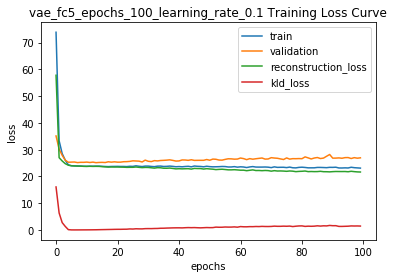

In [60]:
vae.plot_model("./logs/vae/{0}_model_architecture".format(vae.name))
vae.plot_history("./logs/vae/{0}_training_history".format(vae.name))
vae.show_model(logger)
if logger: 
    logger.close()

In [359]:
load_vae = GenerativeVAE(args)
load_vae.load_model("./models/{0}/checkpoint_1000.pt".format(vae.name))
for parameter_name, load_weights in load_vae.model.state_dict().items():
    vae_weights = vae.model.state_dict()[parameter_name]
    assert(torch.all(torch.eq(load_weights, vae_weights)).item())

for (x, _) in test_loader:         
    x = x.to(load_vae.device)
    z, z_mean, z_var = load_vae.encoder(x, reparameterize=True)
    z_mean_2, z_var_2 = vae.encoder(x)
    assert(torch.all(torch.eq(z_mean, z_mean_2)).item())
    assert(torch.all(torch.eq(z_var, z_var_2)).item())
    recon_x = load_vae.decoder(z)
    recon_x_2 = vae.decoder(z)
    loss_1 = vae.elbo_loss(recon_x, x, z_mean, z_var).item()
    loss_2 = vae.elbo_loss(recon_x_2, x, z_mean, z_var).item()
    np.testing.assert_equal(loss_1, loss_2)

(1000, 238, 21)
finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples
finished 300/1000 samples
finished 400/1000 samples
finished 500/1000 samples
finished 600/1000 samples
finished 700/1000 samples
finished 800/1000 samples
finished 900/1000 samples


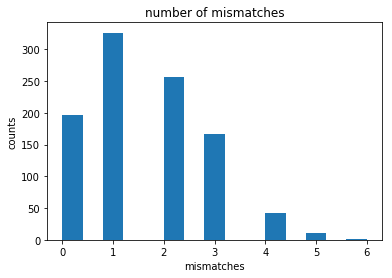

In [364]:
num_samples = 1000
vocabulary = get_all_amino_acids()
num_characters = len(get_all_amino_acids())
index_to_character = dict(zip(range(num_characters), vocabulary))

z = np.random.sample((num_samples, 20))
outputs = vae.model.decode(torch.tensor(z).float())
outputs = outputs.view(outputs.shape[0], -1, num_characters)
outputs = F.softmax(outputs, dim=2)
outputs = outputs.detach().numpy()
print(outputs.shape)
mismatches, all_strings = [], []
for i in range(outputs.shape[0]):
    string = []
    for j in range(outputs.shape[1]):
        k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
        string.append(index_to_character[k])
    all_strings.append("".join(string))
    mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
    if i % 100 == 0:
        print("finished {0}/{1} samples".format(i, num_samples))
        
plt.title("number of mismatches")
plt.hist(mismatches, bins=15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/vae/{0}_mismatches_from_wild_type".format(vae.name))

Text(0,0.5,'counts')

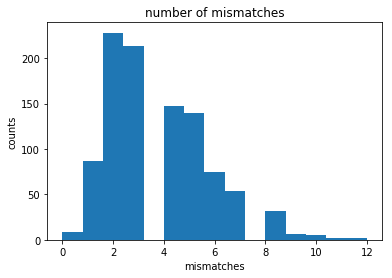

In [363]:
data_mismatches = []
for amino_acid_seq in X_train[0:1000]:
    data_mismatches.append(count_substring_mismatch(amino_acid_seq, wild_type))
plt.title("number of mismatches")
plt.hist(data_mismatches, bins = 15)
plt.xlabel("mismatches")
plt.ylabel("counts")
    

In [362]:
if logger:
    logger.close()

In [ ]:
model = VAE(784, 400, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'logs/vae/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
"""
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
"""
class Args:
    def __init__(self):
        self.batch_size = 128
        self.epochs = 2
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 10
        

args = Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

train(1)

In [33]:
def string_to_index(string, alphabet):
    return np.array([alphabet.index(s) for s in string])

wild_type_index = string_to_index(get_wild_type_amino_acid_sequence(), alphabet = get_all_amino_acids())
wild_type_index_tensor = torch.from_numpy(wild_type_index)

In [52]:
normalized_prob = np.random.randint(0, 21, 21)
normalized_prob = normalized_prob / normalized_prob.sum()
x = torch.tensor([[0] * 15 + [1] + [0] * 5, normalized_prob])
wild_type_probs = []
for probs, index in zip(x, wild_type_index):
    wild_type_probs.append(probs[index])

sums = x.sum(dim = 1)
print(x, sums)
sums = sums - torch.tensor(wild_type_probs)
print(sums)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0822, 0.0137, 0.0320, 0.0091, 0.0639, 0.0776, 0.0046, 0.0502, 0.0776,
         0.0913, 0.0594, 0.0137, 0.0000, 0.0868, 0.0228, 0.0320, 0.0411, 0.0548,
         0.0411, 0.0776, 0.0685]], dtype=torch.float64) tensor([1.0000, 1.0000], dtype=torch.float64)
tensor([1.0000, 0.9087], dtype=torch.float64)


In [55]:
loss = nn.CrossEntropyLoss()
input = torch.randn(2, 3, 4, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [60]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([0, 4, 2])

In [66]:
x = torch.randn(3, 5)
print(x)
x.argmax(dim = 1)

tensor([[-1.4653, -1.0134,  0.0671, -2.0208, -0.0811],
        [-0.5681,  1.4572,  1.2459, -0.1435,  0.7575],
        [ 0.2731, -2.1939,  0.1123, -0.6824,  0.4075]])


tensor([2, 1, 4])

In [63]:
length = 10
wild_type = get_wild_type_amino_acid_sequence()
one_hot = one_hot_encode([wild_type[0:length], wild_type[0:length]], get_all_amino_acids())
for i in range(one_hot.shape[0]): 
    for j in range(one_hot.shape[1]): 
        if not one_hot[i, j]:
            one_hot[i, j] = eps
        else:
            one_hot[i, j] = 1
            
one_hot_tensor = torch.from_numpy(one_hot)
print(one_hot_tensor.shape)
labels = one_hot_tensor.view(2, length, len(get_all_amino_acids())).argmax(dim = 2).float()
print(labels.shape)
print(one_hot_tensor.view(2, length, len(get_all_amino_acids()))[0][0])
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1).shape)
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)[0, :, 0])
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)[0, 16])
x = one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)
z = nn.CrossEntropyLoss(reduction='sum')(x, labels).item()
print(z)

torch.Size([2, 210])
torch.Size([2, 10])
tensor([-1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08,  1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08], dtype=torch.float64)
torch.Size([2, 21, 10])
tensor([-1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08,  1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08], dtype=torch.float64)
tensor([ 1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08],
       dtype=torch.float64)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [46]:
eps = -1e8
x = torch.tensor(np.array([[1, eps, eps], [eps, 1, eps]])).float()
labels = torch.tensor(np.array([0, 1]))
print(torch.all(torch.eq(x.argmax(1), labels)).item() == 1)
F.cross_entropy(x, labels, reduction='sum')

True


tensor(0.)

In [32]:
[x if x else eps for x in one_hot[0]]

(2, 63)

In [175]:
x = torch.randn(3, 3, 5)


tensor([[[-2.1489, -1.4456, -3.2613, -3.3038, -0.5574],
         [-2.2018, -1.3564, -1.8980, -0.8716, -2.7541],
         [-1.0349, -1.3823, -1.8581, -3.3522, -1.5958]],

        [[-1.8522, -3.5563, -0.7642, -3.0691, -1.1961],
         [-2.2367, -2.4859, -0.9454, -2.5285, -1.0740],
         [-1.3448, -2.4309, -1.0460, -2.8123, -1.4270]],

        [[-3.8434, -0.5309, -2.8926, -2.6222, -1.3378],
         [-2.8145, -2.0604, -0.9137, -1.0996, -2.5432],
         [-0.4621, -2.3404, -2.8733, -2.2319, -2.2081]]])

In [179]:
z = F.log_softmax(x, dim=2)
z

tensor([[[-2.1489, -1.4456, -3.2613, -3.3038, -0.5574],
         [-2.2018, -1.3564, -1.8980, -0.8716, -2.7541],
         [-1.0349, -1.3823, -1.8581, -3.3522, -1.5958]],

        [[-1.8522, -3.5563, -0.7642, -3.0691, -1.1961],
         [-2.2367, -2.4859, -0.9454, -2.5285, -1.0740],
         [-1.3448, -2.4309, -1.0460, -2.8123, -1.4270]],

        [[-3.8434, -0.5309, -2.8926, -2.6222, -1.3378],
         [-2.8145, -2.0604, -0.9137, -1.0996, -2.5432],
         [-0.4621, -2.3404, -2.8733, -2.2319, -2.2081]]])

In [186]:
x = torch.zeros(3, 3, 5)
x[:, :, 4] = 1
x

tensor([[[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]]])

In [188]:
-(z * x).sum()

tensor(14.6936)

In [8]:
torch.randn(3, 4, 5).permute(0, 2, 1).shape

torch.Size([3, 5, 4])